## Argo File Loader

In [1]:
# try with newest snapshot
# try with ftp that gmaze used in issue, probably going to be really slow

In [7]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import argopy
import scipy.ndimage as filter
import scipy
import matplotlib
import gsw
import traceback
from importlib import reload

import argopy
from argopy import DataFetcher as ArgoDataFetcher

argo_loader = ArgoDataFetcher(
    src="gdac", ftp="/swot/SUM05/dbalwada/Argo_sync", progress=True
)

In [8]:
#print('argopy: {}, xarray: {}, dask: {}'.format(argopy.__version__, xr.__version__, dask.__version__))

In [9]:
import os
os.chdir('/home.ufs/amf2288/argo-intern/funcs')
import density_funcs as df
import EV_funcs as ef
import filt_funcs as ff
import plot_funcs as pf
import processing_funcs as prf
#import argopy_investigation as ai

In [38]:
reload(df)
reload(ef)
reload(ff)
reload(pf)
#reload(mf)
reload(prf)

<module 'processing_funcs' from '/home/amf2288/argo-intern/funcs/processing_funcs.py'>

In [30]:
np.all(standard_grid >= 0)

True

# Correcting Interpolation Errors

In [231]:
ds = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/no_interp.nc')

In [232]:
ds_interp = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/interp.nc')

In [233]:
print(f"The original     dataset has {len(ds.N_PROF)} profiles.")
print(f"The interpolated dataset has {len(ds_interp.N_PROF)} profiles.")

The original     dataset has 1641 profiles.
The interpolated dataset has 1193 profiles.


This is troubling. We've gotten a lot closer; using the old interpolation function would result in about 300 profiles, and now we have about 1200. But there's still about 450 "missing" profiles that disappear somewhere in the interpolation step. These are the things I've checked so far:
- Only 2 profiles are thrown out because they don't have enough data to interpolate
- The number of profiles with QC flags of 2 is too small to account for the discrepency.
- I'm not totally sure what else to check at this point....

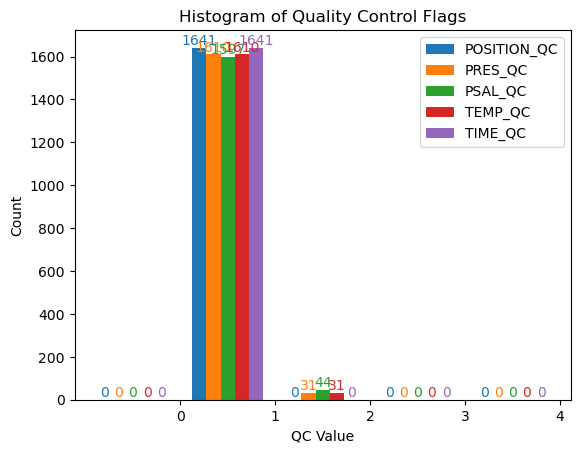

In [234]:
# List of the variables to plot
variables = ['POSITION_QC', 'PRES_QC', 'PSAL_QC', 'TEMP_QC', 'TIME_QC']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
bar_width = 0.15

fig, ax = plt.subplots()

start = 0
stop = 5

# Loop through each variable and plot its histogram
for i, var in enumerate(variables):
    counts, bins = np.histogram(ds[var], bins=np.arange(start-0.5, stop+0.5, 1))
    bars = ax.bar(bins[:-1] + i * bar_width, counts, width=bar_width, color=colors[i], label=var)
    
    # Add text annotations for each bin
    for bar, count in zip(bars, counts):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), int(count), ha='center', va='bottom', color=colors[i])

# Add labels and title
ax.set_xlabel('QC Value')
ax.set_ylabel('Count')
ax.set_title('Histogram of Quality Control Flags')
ax.set_xticks(np.arange(start, stop, 1) + bar_width * (len(variables) - 1) / 2)
ax.set_xticklabels(np.arange(start, stop, 1))
ax.legend()

# Display the plot
plt.show()


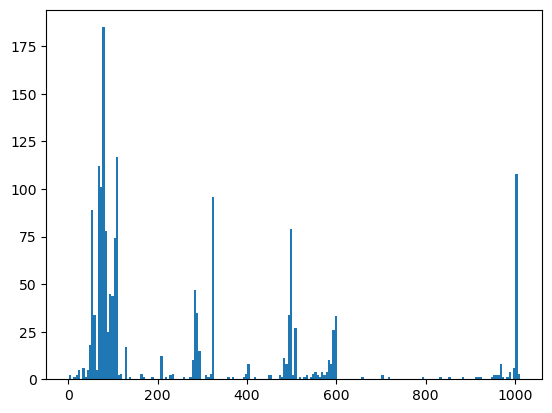

In [235]:
non_nan_counts = np.sum(~np.isnan(ds.PRES), axis=1)
plt.hist(non_nan_counts,bins=np.arange(non_nan_counts.min(),non_nan_counts.max(),5));

## Remaining Issues??

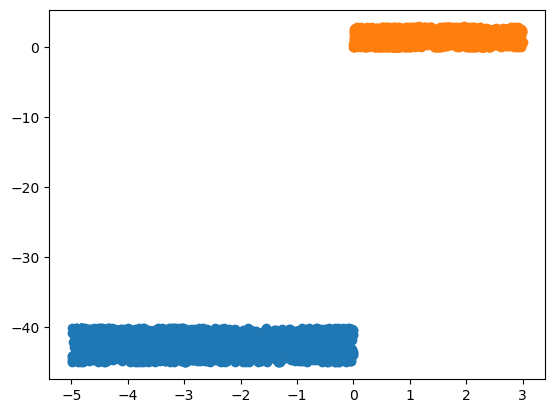

In [236]:
plt.scatter(ds.LONGITUDE,ds.LATITUDE)
plt.scatter(ds_interp.LONGITUDE,ds_interp.LATITUDE)

In [237]:
# Combine PLATFORM_NUMBER and CYCLE_NUMBER into unique identifiers for each dataset
ds_pairs = set(zip(ds['PLATFORM_NUMBER'].values, ds['CYCLE_NUMBER'].values))
ds_interp_pairs = set(zip(ds_interp['PLATFORM_NUMBER'].values, ds_interp['CYCLE_NUMBER'].values))

# Calculate the groups
identical_pairs = ds_pairs & ds_interp_pairs  # Intersection: present in both
unique_to_ds = ds_pairs - ds_interp_pairs    # Unique to ds
unique_to_ds_interp = ds_interp_pairs - ds_pairs  # Unique to ds_interp

# Output the results
print("Identical pairs:", len(identical_pairs))
print("Unique to ds:", len(unique_to_ds))
print("Unique to ds_interp:", len(unique_to_ds_interp))

Identical pairs: 0
Unique to ds: 1638
Unique to ds_interp: 1190


In [151]:
ds['NUM'] = xr.DataArray(
    np.char.add(
        ds.PLATFORM_NUMBER.astype(str).str.zfill(7).values, 
        ds.CYCLE_NUMBER.astype(str).str.zfill(3).values
    ),
    dims=["N_PROF"]
)

ds_interp['NUM'] = xr.DataArray(
    np.char.add(
        ds_interp.PLATFORM_NUMBER.astype(str).str.zfill(7).values, 
        ds_interp.CYCLE_NUMBER.astype(str).str.zfill(3).values
    ),
    dims=["N_PROF"]
)

ds = ds.set_coords('NUM')
ds_interp = ds_interp.set_coords('NUM')

ds['PROF'] = ds.NUM.astype(int)
ds_interp['PROF'] = ds_interp.NUM.astype(int)

ds = ds.set_coords('PROF')
ds_interp = ds_interp.set_coords('PROF')

ds = ds.drop('NUM')
ds_interp = ds_interp.drop('NUM')

/tmp/ipykernel_70150/3020474872.py:26: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds = ds.drop('NUM')
/tmp/ipykernel_70150/3020474872.py:27: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_interp = ds_interp.drop('NUM')


In [173]:
ds = ds.sortby('PROF')
ds_interp = ds_interp.sortby('PROF')

In [189]:
# Convert PROF coordinates to sets
prof_ds = set(ds.PROF.values)
prof_ds_interp = set(ds_interp.PROF.values)

# Shared PROF values
shared_prof = list(prof_ds & prof_ds_interp)

# Unique PROF values in ds
unique_to_ds = list(prof_ds - prof_ds_interp)

# Unique PROF values in ds_interp
unique_to_ds_interp = list(prof_ds_interp - prof_ds)

## Filling in gaps

In [ ]:
boxes = [[-165,-160,-55,-50,0,2002], #done
         [-120,-115,-15,-10,0,2002], #done
         [-100,-95,-65,-60,0,2002],  #done
         [-15,10,50,55,0,2002],      #done
         [-10,5,60,65,0,2002],       #done
         [0,5,65,70,0,2002],         #done
         [55,65,-5,0,0,2002],        #done
         [80,85,5,10,0,2002],        #done
         [65,70,-60,-55,0,2002],     #done
         [135,140,20,25,0,2002],     #done
         [160,165,45,50,0,2002],     #done
         [170,175,30,35,0,2002],     #done
         [5,10,0,5,0,2002],          #done
         [65,70,-60,-55,0,2002],     #done
         [80,85,5,10,0,2002]]        #done

In [66]:
multi_boxes = [[-30,-25,-10,-5,0,2002], #done
               [-30,-5,30,40,0,2002],   #done
               [-15,0,40,45,0,2002],    #done
               [-20,0,45,50,0,2002],    #done
               [30,40,-70,-65,0,2002],  #done
               [60,70,20,25,0,2002],    #done
               [115,120,15,25,0,2002],  #done
               [120,140,15,20,0,2002],  #done
               [125,135,10,15,0,2002],  #done
               [55,65,-5,0,0,2002],     #done
               [-15,5,55,60,0,2002]]    #

In [87]:
box = multi_boxes[10]
box

[-15, 5, 55, 60, 0, 2002]

In [88]:
box_interp = prf.get_box(box)
print('box_interp loaded')
box_interp.to_netcdf("/swot/SUM05/amf2288/sync-boxes/new_test/lon:({},{})_lat:({},{})_ds_z.nc".format(box[0],box[1],box[2],box[3]))
print('box_interp saved')

loading points complete
USING LOCAL ARGOPY DIRECTORY
to xarray complete
point to profile complete
NEW INTERP FUNCTION
	Profile 271 has invalid depth range: depth_min=1158.0, depth_max=1156
	Profile 292 has invalid depth range: depth_min=818.0, depth_max=818
	Profile 595 skipped due to interpolation error: Standard levels must be a list or a numpy array of positive and sorted values
	Profile 599 skipped due to interpolation error: Standard levels must be a list or a numpy array of positive and sorted values
	Profile 603 skipped due to interpolation error: Standard levels must be a list or a numpy array of positive and sorted values
	Profile 609 skipped due to interpolation error: Standard levels must be a list or a numpy array of positive and sorted values
	Profile 613 skipped due to interpolation error: Standard levels must be a list or a numpy array of positive and sorted values
	Profile 619 skipped due to interpolation error: Standard levels must be a list or a numpy array of positiv

# Testing Problem Boxes

In [275]:
ds_interp.attrs['raw_attrs'] = ''
ds.attrs['raw_attrs'] = ''

In [276]:
ds.to_netcdf('/swot/SUM05/amf2288/sync-boxes/ds_3.nc')
ds_interp.to_netcdf('/swot/SUM05/amf2288/sync-boxes/ds_interp_3.nc')

In [277]:
ds_1 = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_1.nc')
ds_interp_1 = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_interp_1.nc')

ds_2 = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_2.nc')
ds_interp_2 = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_interp_2.nc')

ds_3 = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_3.nc')
ds_interp_3 = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_interp_3.nc')

ds_4 = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_4.nc')
ds_interp_4 = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_interp_4.nc')

ds_5 = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_5.nc')
ds_interp_5 = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_interp_5.nc')

In [278]:
print(f"ds_1        has {len(ds_1.N_PROF)} profiles.")
print(f"ds_interp_1 has {len(ds_interp_1.N_PROF)} profiles.")
print(f"ds_2        has {len(ds_2.N_PROF)} profiles.")
print(f"ds_interp_2 has {len(ds_interp_2.N_PROF)} profiles.")
print(f"ds_3        has {len(ds_3.N_PROF)} profiles.")
print(f"ds_interp_3 has {len(ds_interp_3.N_PROF)} profiles.")
print(f"ds_4        has {len(ds_4.N_PROF)} profiles.")
print(f"ds_interp_4 has {len(ds_interp_4.N_PROF)} profiles.")
print(f"ds_5        has {len(ds_5.N_PROF)} profiles.")
print(f"ds_interp_5 has {len(ds_interp_5.N_PROF)} profiles.")

ds_1        has 1649 profiles.
ds_interp_1 has 1648 profiles.
ds_2        has 1680 profiles.
ds_interp_2 has 1680 profiles.
ds_3        has 1807 profiles.
ds_interp_3 has 1807 profiles.
ds_4        has 1398 profiles.
ds_interp_4 has 1398 profiles.
ds_5        has 2820 profiles.
ds_interp_5 has 2815 profiles.


In [ ]:
ds_interp

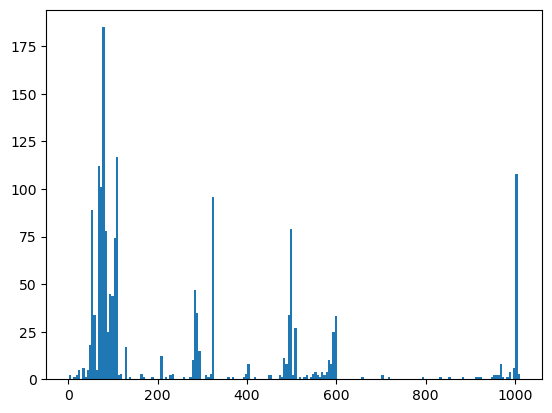

In [9]:
plt.hist(non_nan_counts,bins=np.arange(non_nan_counts.min(),non_nan_counts.max(),5));

In [10]:
depth_maxes = []

for prof in ds.N_PROF:
    depth_max = ds.sel(N_PROF=prof).PRES.max()
    depth_maxes.append(depth_max)

(array([  2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          1.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

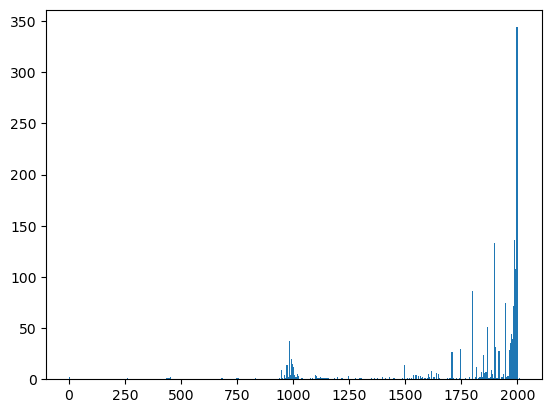

In [12]:
plt.hist(depth_maxes,bins=np.arange(np.min(depth_maxes), np.max(depth_maxes),5))

In [10]:
print("There are {} profiles in the original dataset".format(len(ds.N_PROF)))
print("There are {} profiles in the interpolated dataset".format(len(ds_interp.N_PROF)))

There are 1640 profiles in the original dataset
There are 258 profiles in the interpolated dataset


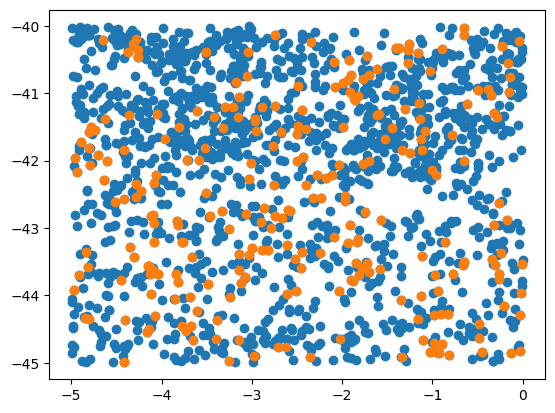

In [11]:
plt.scatter(ds.LONGITUDE, ds.LATITUDE)
plt.scatter(ds_interp.LONGITUDE, ds_interp.LATITUDE)

In [8]:
ds.to_netcdf("/swot/SUM05/amf2288/sync-boxes/globe_load/lon:({},{})_lat:({},{})_ds_z.nc".format(box[0],box[1],box[2],box[3]))

TypeError: Invalid value for attr 'raw_attrs': {'raw_attrs': {'title': 'Argo float vertical profile', 'institution': 'FR GDAC', 'source': 'Argo float', 'history': '2019-04-03T16:03:43Z creation', 'references': 'http://www.argodatamgt.org/Documentation', 'user_manual_version': '3.1', 'Conventions': 'Argo-3.1 CF-1.6', 'featureType': 'trajectoryProfile'}, 'Processing_history': "Transformed with 'profile2point'"}. For serialization to netCDF files, its value must be of one of the following types: str, Number, ndarray, number, list, tuple

## testing parallel loading with dask client

In [ ]:
from dask.distributed import Client

In [ ]:
client= Client(processes=True)

In [ ]:
print(client)

In [ ]:
box = [-27.5, -22.5, -5, 5, 0, 2001]

In [ ]:
%%time
with argopy.set_options(parallel=client):
    f = DataFetcher(src='gdac', ftp='/swot/SUM05/dbalwada/Argo_sync', progress=True).region(box)
    print('%i chunks to process' % len(f.uri))
    print(f)
    ds = f.load().data#.to_xarray()

Okay the process is running on multiple GPUs, in this case 10-12 machines. However, obviously there are a ton of error messages---I'm not really sure what's going wrong. The box I've started with is really small, so I don't think there should be a memory error. Not sure where to go from here.

## Load by box (coordinate: N_PROF)

In [5]:
#box=[lon_min,lon_max,lat_min,lat_max,depth_min,depth_max]
box_atl = [-25,-20,-70,70,0,2001]
box_pac = [-180,-175,-70,70,0,2001]
box_watl = [-60,-55,10,45,0,2001]
box_wpac = [150,155,-5,50,0,2001]
box_wind = [60,65,-65,25,0,2001]

In [6]:
NW = [-180,0,0,90,0,2001]
NE = [0,180,-90,0,0,2001]
SW = [-180,0,-90,0,0,2001]
SE = [0,-180,-90,0,0,2001]

In [7]:
box1 = [-180,-90,  0,90,0,2001]
box2 = [- 90,  0,  0,90,0,2001]
box3 = [   0, 90,  0,90,0,2001]
box4 = [  90,180,  0,90,0,2001]
box5 = [-180,-90,-90, 0,0,2001]
box6 = [- 90,  0,-90, 0,0,2001]
box7 = [   0, 90,-90, 0,0,2001]
box8 = [  90,180,-90, 0,0,2001]

In [8]:
#pf.plot_box([NW,NE,SW,SE])

In [55]:
ds = prf.get_box([-35,-30,-65,-60,0,2000],2)

loading points complete
to xarray complete
point to profile complete
interpolation complete
adding spice complete


In [ ]:
ds = ds.assign_attrs({"Fetched_uri":''})
ds

In [ ]:
ds.to_netcdf("/swot/SUM05/amf2288/sync-boxes/lon:({},{})_lat:({},{})_ds_z.nc".format(NW[0],NW[1],NW[2],NW[3]))

In [ ]:
box_1x = [-10,0,-10,0,0,2000]   #error
box_1y = [-10,0,-20,-10,0,2000] #done
box_1z = [-10,0,-30,-20,0,2000] #done
box_1a = [-10,0,-40,-30,0,2000] #done
box_1b = [-10,0,-50,-40,0,2000] #done
box_1c = [-10,0,-60,-50,0,2000] #done
box_1d = [-10,0,-70,-60,0,2000] #done
box_long=[-10,-8,-70,-10,0,2000]

In [ ]:
pf.plot_box([box_1x,box_1y,box_1z,box_1a,box_1b,box_1c,box_1d,box_long])

In [ ]:
ds_z=ff.get_box(box_long,4)

In [ ]:
ds['N_PROF'].attrs = {'name':'Fetched Profile Number'}
ds['PRES_INTERPOLATED'].attrs = {'name':'Interpolated Pressure', 'units':'dbar', 'notes':'interpolated to standard pressure grid of 2m'}

ds['N_PROF_NEW'].attrs = {'name':'Sequential Profile Number'}
ds['LATITUDE'].attrs = {'name':'Latitude', 'units':'°N'}
ds['LONGITUDE'].attrs = {'name':'Longitude', 'units':'°E'}
ds['month'].attrs = {'name':'Month'}
ds['year'].attrs = {'name':'Year'}
ds['MLD'].attrs = {'name':'Mixed Layer Depth', 'units':'m'}

ds['CT'].attrs = {'name':'Conservative Temperature', 'units':'°C'}
ds['SA'].attrs = {'name':'Absolute Salinity', 'units':'g kg-1'}
ds['SIG0'].attrs = {'name':'Potential Density', 'units':'kg m-1', 'notes':'referenced to 0 dbar'}
ds['SPICE'].attrs = {'name':'Spiciness', 'units':'kg m-1', 'notes':'referenced to 0 dbar'}                  
ds = ds.assign_attrs({"Fetched_uri":''})

In [ ]:
ds_z

In [ ]:
plt.scatter(ds_z.LONGITUDE, ds_z.LATITUDE)

In [ ]:
ds_z.to_netcdf("202206_boxes/lon:({},{})_lat:({},{})_ds_z.nc".format(box_long[0],box_long[1],box_long[2],box_long[3]))

In [ ]:
erddap_loader=ArgoDataFetcher(src'erddap',parallel=True,progress=True)

In [ ]:
gmaze_loader=ArgoDataFetcher(src='gdac',ftp='https://data-argo.ifremer.fr/',parallel=True,progress=True)

In [ ]:
usa_loader=ArgoDataFetcher(src='gdac',ftp='ftp://usgodae.org/pub/outgoing/argo',parallel=True,progress=True)

In [ ]:
ds=argo_loader.region(box_1x)
print('loading points complete')
ds=ds.to_xarray()
print('to xarray complete')

In [ ]:
ds=ds.argo.teos10(['CT','SA','SIG0'])
ds=ds.argo.point2profile()
print('point to profile complete')

In [ ]:
def test_get_box(box,sample_min):
    '''Takes latitude/longitude/depth data and a sample rate and returns an xarray with CT, SA, SIG0, and SPICE interpolated to a pressure grid of 2m. 
    
    box: lat/lon in the form: box=[lon_min, lon_max, lat_min, lat_max, depth_min, depth_max]
    sample_min: minimum sample rate [m]
    '''
    
    ds=argo_loader.region(box)
    print('loading points complete')
    
    ds=ds.to_xarray()
    print('to xarray complete')
    
    ds=ds.argo.teos10(['CT','SA','SIG0'])
    ds=ds.argo.point2profile()
    print('point to profile complete')
    
    ds_interp=get_ds_interp(ds,0,2000,sample_min)
    print('interpolation complete')
    
    ds_interp['SPICE'] = gsw.spiciness0(ds_interp.SA,ds_interp.CT).rename('SPICE')
    print('adding spice complete')
        
    return ds_interp

In [ ]:
test = test_get_box(box_medi,4)

In [ ]:
ds=argo_loader.region(box_medi)

In [ ]:
ds = ds.data

In [ ]:
ds

In [ ]:
ds.PSAL.dropna('N_POINTS')

In [ ]:
for n in range(0,len(ds.N_PROF)):
    

In [ ]:
'''
methods are also functions, but specific to the class they're applied to
class (animals) --> subclass (dogs) --> object (golden retriever)
open_mfdataset() from xarray, for opening data in multiple netcdfs
1) write loop opening all files yourself, check for PSAL, if not there remove file
2) go into open_mfdataset() and see if there's a loop there to exploit instead

locally install repo (pip install -e??)
uses the code from the local repo instead
then make changes to repo: print statement in part of the code we think is happening
then work on loops, etc.


'''

In [ ]:
def to_xarray(self, errors: str = "ignore"):
        """ Load Argo data and return a :class:`xarray.Dataset`

        Parameters
        ----------
        errors: str, default='ignore'
            Define how to handle errors raised during data URIs fetching:

                - 'ignore' (default): Do not stop processing, simply issue a debug message in logging console
                - 'silent':  Do not stop processing and do not issue log message
                - 'raise': Raise any error encountered

        Returns
        -------
        :class:`xarray.Dataset`
        """
        if (
            len(self.uri) > 50
            and isinstance(self.method, str)
            and self.method == "sequential"
        ):
            warnings.warn(
                "Found more than 50 files to load, this may take a while to process sequentially ! "
                "Consider using another data source (eg: 'erddap') or the 'parallel=True' option to improve processing time."
            )
        elif len(self.uri) == 0:
            raise DataNotFound("No data found for: %s" % self.indexfs.cname)

        # Download data:
        ds = self.fs.open_mfdataset(
            self.uri, #list of all float files?
            method=self.method,
            concat_dim="N_POINTS",
            concat=True,
            preprocess=self._preprocess_multiprof,
            progress=self.progress,
            errors=errors,
            open_dataset_opts={'xr_opts': {'decode_cf': 1, 'use_cftime': 0, 'mask_and_scale': 1}},
        )

        # Data post-processing:
        ds["N_POINTS"] = np.arange(
            0, len(ds["N_POINTS"])
        )  # Re-index to avoid duplicate values
        ds = ds.set_coords("N_POINTS")
        ds = ds.sortby("TIME")

        # Remove netcdf file attributes and replace them with simplified argopy ones:
        ds.attrs = {}
        if self.dataset_id == "phy":
            ds.attrs["DATA_ID"] = "ARGO"
        if self.dataset_id == "bgc":
            ds.attrs["DATA_ID"] = "ARGO-BGC"
        ds.attrs["DOI"] = "http://doi.org/10.17882/42182"
        ds.attrs["Fetched_from"] = self.server
        ds.attrs["Fetched_by"] = getpass.getuser()
        ds.attrs["Fetched_date"] = pd.to_datetime("now", utc=True).strftime("%Y/%m/%d")
        ds.attrs["Fetched_constraints"] = self.cname()
        if len(self.uri) == 1:
            ds.attrs["Fetched_uri"] = self.uri[0]
        else:
            ds.attrs["Fetched_uri"] = ";".join(self.uri)

        return ds

In [ ]:
print(ds_z.SIG0.values.min(), ds_z.SIG0.values.max())

In [ ]:
rho_grid = np.linspace(26.6, 28, 1001)

In [ ]:
ds_rho = df.interpolate2density_prof(ds_z, rho_grid)

In [ ]:
ds_rho

In [ ]:
ds_rho.to_netcdf("202206_boxes/lon:({},{})_lat:({},{})_ds_rho.nc".format(box[0],box[1],box[2],box[3]))

## Load by float (coordinate: distance)

In [ ]:
float_ID = 6901265

In [ ]:
ds_z = ff.get_float(float_ID, 4)

In [ ]:
ds_z = ds_z.assign_attrs({"Fetched_uri":''})

In [ ]:
ds_z

In [ ]:
ds_z.to_netcdf("202206_floats/float_ID:({})_ds_z.nc".format(float_ID))

In [ ]:
print(ds_z.SIG0.values.min(), ds_z.SIG0.values.max())

In [ ]:
rho_grid = np.linspace(26.4, 28, 1001)

In [ ]:
ds_rho = df.interpolate2density_prof(ds_z, rho_grid)

In [ ]:
ds_rho

In [ ]:
ds_rho.to_netcdf("202206_floats/float_ID:({})_ds_rho.nc".format(float_ID))

## Loading Boxes by Degree

In [ ]:
lons = np.arange(-180,181,4)
lats = np.arange(-90,91,4)

boxes=[]

for n in range(0,len(lons)-1):
    for m in range(0,len(lats-1)):
        lon_min = lons[n]
        lon_max = lons[n+1]
        lat_min = lats[n]
        lat_max = lats[n+1]
        box_n = np.array([lon_min, lon_max, lat_min, lat_max])
        boxes.append(box_n)

In [ ]:
n=0
lons[n+1]

In [ ]:
from argopy import IndexFetcher as ArgoIndexFetcher

box_bad=[-15,-14,36.5,37]#, '2000-01-01', '2021-06'] # need to remove pressure poinds because the region function for this index fetcher seems a bit different.

idx = ArgoIndexFetcher(src='gdac',dataset='phy',mode='standard',
                            ftp="/swot/SUM05/dbalwada/202203-ArgoData").region(box_bad).load()
idx.index

In [ ]:
float_IDs = [1900041,1900749,]